### Compute an approximate zeropoint for the COSMOS source dataset from the catalog `MAG_AUTO` and total stamp flux

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from os.path import expanduser
from wlenet import config
from wlenet.misc.gpu import avoid_gpu_in_this_process; avoid_gpu_in_this_process()

from multiprocessing import Pool, cpu_count
import astropy.io.fits as pyfits

In [2]:
save_zeropoint = False

In [3]:
num_image_files = 88
rgc_path = '~/datasets/wlenet/cosmos/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits'
rgc_dir, rgc_file = os.path.split(os.path.expanduser(rgc_path))
fits_file = os.path.splitext(rgc_file)[0] + '_fits.fits'
mask_info_file = 'real_galaxy_mask_info.fits'
selection_info_file = 'real_galaxy_selection_info.fits'
rgc_catalog = pyfits.getdata(os.path.join(rgc_dir, rgc_file))
fit_catalog = pyfits.getdata(os.path.join(rgc_dir, fits_file))

In [4]:
def get_galaxy_images(galaxy_image_filename):
    
    image_path = rgc_dir + '/' + galaxy_image_filename
    f = pyfits.open(image_path, memmap=True)
    gal_ims = [f[i].data for i in range(len(f))]
    return gal_ims

In [5]:
mp_pool_size = cpu_count() - 1
pool = Pool(mp_pool_size)
galaxy_image_filenames = ['real_galaxy_images_25.2_n%d.fits' % (i+1) for i in range(num_image_files)]
file_gal_ims = pool.map(get_galaxy_images, galaxy_image_filenames)
name_to_num = dict(zip(galaxy_image_filenames, range(num_image_files)))

In [6]:
stamps = [file_gal_ims[name_to_num[rgc_catalog['GAL_FILENAME'][i]]][rgc_catalog['GAL_HDU'][i]] for i in range(rgc_catalog.size)]

In [7]:
mag_auto = fit_catalog['mag_auto']
stamp_flux = np.array([np.sum(s) for s in stamps])

/cs/phd/springer/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


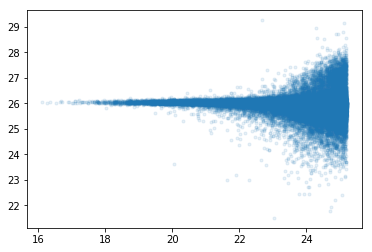

In [8]:
plt.plot(mag_auto, mag_auto + 2.5*np.log10(stamp_flux), '.', alpha=0.1)

In [9]:
cosmos_zeropoint = np.nanmean(mag_auto + 2.5*np.log10(stamp_flux))
print('cosmos_zeropoint =', cosmos_zeropoint)

cosmos_zeropoint = 25.95534132104084


/cs/phd/springer/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [10]:
if save_zeropoint:
    cosmos_zeropoint_path = expanduser(config['calibration_path'] + '/cosmos_zeropoint.npy')
    np.save(cosmos_zeropoint_path, cosmos_zeropoint)